In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import uuid
import tensorflow as tf

from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import save_img
from tensorflow.data import Dataset, AUTOTUNE
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Rescaling, Dropout
from tensorflow import Tensor, concat
from tensorflow.keras.callbacks import History, EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, Accuracy
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import accuracy_score

RANDOM_SEED = 42

In [2]:
os.makedirs("models", exist_ok=True)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_dir = "/content/drive/MyDrive/skin cancer/Melanoma_Cancer_Image_Dataset/test"
train_ds, val_ds = image_dataset_from_directory(
  data_dir,
  labels='inferred',
  validation_split=0.2,
  image_size=(128, 128),
  subset="both",
  seed=RANDOM_SEED,
  pad_to_aspect_ratio=True,
  shuffle=True,
  batch_size=32)
train_ds

Found 2000 files belonging to 2 classes.
Using 1600 files for training.
Using 400 files for validation.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [5]:
class_names: list[str] = train_ds.class_names
print(class_names)
num_classes = 2

['Benign', 'Malignant']


In [6]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

In [7]:
es = EarlyStopping(
    monitor="val_loss",
    patience=5, #how many consecutive epochs
    verbose=1,
    restore_best_weights=True
)
es

In [8]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(128,128,3))
base.trainable = False

x = GlobalAveragePooling2D()(base.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(x)
output = Dense(2, activation="softmax")(x)

effnet_model = Model(inputs=base.input, outputs=output)
effnet_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [9]:
effnet_model.summary()

history_effnet = effnet_model.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=[es])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 128, 128,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 128, 128,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 129, 129,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 64, 64,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 64, 64,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 64, 64,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 64, 64,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 64, 64,    │        512 │ block1a_se_excit

 Total params: 4,378,021 (16.70 MB)

 Trainable params: 328,450 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 457s 9s/step - accuracy: 0.7876 - loss: 0.4468 - val_accuracy: 0.9100 - val_loss: 0.2337
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.8974 - loss: 0.2512 - val_accuracy: 0.9300 - val_loss: 0.2108
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.9306 - loss: 0.1951 - val_accuracy: 0.9350 - val_loss: 0.1983
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 76s 993ms/step - accuracy: 0.9424 - loss: 0.1443 - val_accuracy: 0.9400 - val_loss: 0.1964
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.9362 - loss: 0.1513 - val_accuracy: 0.9350 - val_loss: 0.2152
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9566 - loss: 0.1138 - val_accuracy: 0.9375 - val_loss: 0.2081
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 50s 993ms/step - accuracy: 0.9611 - loss: 0.1075 - val_accuracy: 0.9400 - val_loss: 0.2112
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 81s 980ms/step - accuracy: 0.9695 - loss: 0.0918 - val_accuracy: 0.9475 -

In [10]:
malignant_index = class_names.index("Malignant")
print(class_names)
y_pred_prob = effnet_model.predict(val_ds)
y_pred = np.argmax(y_pred_prob, axis=1)
y_malignant_prob = y_pred_prob[:, malignant_index]
threshold = 0.5  #we can change the threshold to improve the recall

y_pred = (y_malignant_prob >= threshold).astype(int)

['Benign', 'Malignant']
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 951ms/step


In [11]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
y_true = np.concatenate([y.numpy() for _, y in val_ds])

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='binary')
accuracy = accuracy_score(y_true, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
from sklearn.metrics import classification_report

print(classification_report(
    y_true,
    y_pred,
    target_names=class_names
))

Precision: 0.9402374188311688
Recall: 0.9587155963302753
Accuracy: 0.94
              precision    recall  f1-score   support

      Benign       0.95      0.92      0.93       182
   Malignant       0.93      0.96      0.95       218

    accuracy                           0.94       400
   macro avg       0.94      0.94      0.94       400
weighted avg       0.94      0.94      0.94       400



In [12]:
MODEL_PATH = "models/effnet_model.keras"
effnet_model.save(MODEL_PATH)

In [13]:
from tensorflow.keras.applications import VGG16, EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D
num_classes=2
effnet_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(128,128,3))
effnet_base.trainable = False

effnet_model = Sequential([
    effnet_base,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

effnet_model.compile(optimizer=Adam(1e-4),
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
effnet_model.summary()

history_effnet = effnet_model.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=[es])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 4, 4, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,378,021 (16.70 MB)

 Trainable params: 328,450 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.6321 - loss: 0.6352 - val_accuracy: 0.8650 - val_loss: 0.3569
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.8518 - loss: 0.3714 - val_accuracy: 0.8800 - val_loss: 0.2927
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 79s 970ms/step - accuracy: 0.8759 - loss: 0.3077 - val_accuracy: 0.8925 - val_loss: 0.2589
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.8953 - loss: 0.2642 - val_accuracy: 0.9050 - val_loss: 0.2383
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 82s 999ms/step - accuracy: 0.8951 - loss: 0.2492 - val_accuracy: 0.9150 - val_loss: 0.2261
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.9065 - loss: 0.2487 - val_accuracy: 0.9150 - val_loss: 0.2159
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9147 - loss: 0.2268 - val_accuracy: 0.9175 - val_loss: 0.2092
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9300 - loss: 0.1935 - val_accuracy: 0.9325 - val

In [14]:
effnet_model.save("models/effnet_model.keras")

In [15]:
malignant_index = class_names.index("Malignant")
print(class_names)
y_pred_prob = effnet_model.predict(val_ds)
y_pred = np.argmax(y_pred_prob, axis=1)
y_malignant_prob = y_pred_prob[:, malignant_index]
threshold = 0.25  #we can change the threshold to improve the recall

y_pred = (y_malignant_prob >= threshold).astype(int)

['Benign', 'Malignant']
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 775ms/step


In [16]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
y_true = np.concatenate([y.numpy() for _, y in val_ds])

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='binary')
accuracy = accuracy_score(y_true, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
from sklearn.metrics import classification_report

print(classification_report(
    y_true,
    y_pred,
    target_names=class_names
))

Precision: 0.9323149006281537
Recall: 0.9724770642201835
Accuracy: 0.93
              precision    recall  f1-score   support

      Benign       0.96      0.88      0.92       182
   Malignant       0.91      0.97      0.94       218

    accuracy                           0.93       400
   macro avg       0.93      0.93      0.93       400
weighted avg       0.93      0.93      0.93       400



In [17]:
def plot_history(history, effnet_model):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Accuracy plot
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1,2,2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


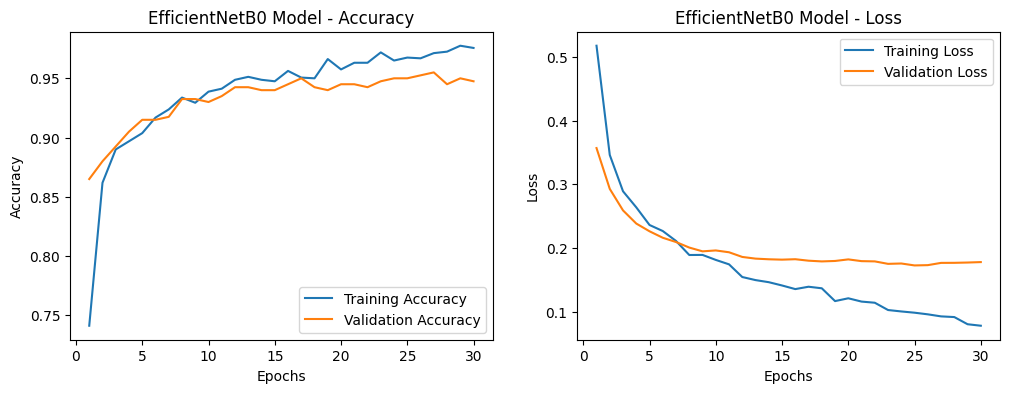

In [18]:
model_name = "EfficientNetB0 Model" # Define model_name before calling plot_history
plot_history(history_effnet, effnet_model)

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_conf_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
    disp.plot(cmap='Blues')
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()


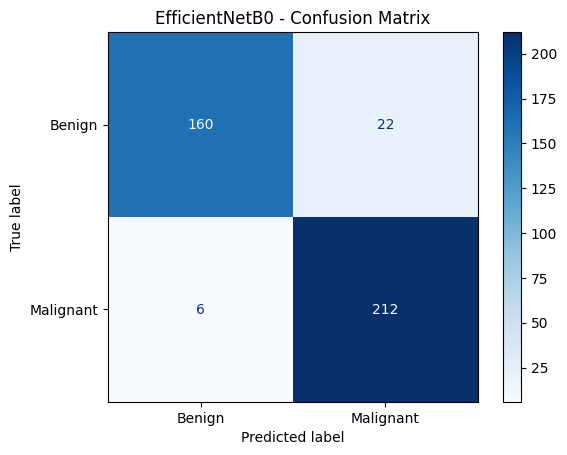

In [20]:
plot_conf_matrix(y_true, y_pred, "EfficientNetB0")


In [21]:
!pip install -q streamlit tensorflow pillow
!apt-get install -y nodejs npm > /dev/null
!curl -LO https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64.deb
!dpkg -i cloudflared-linux-amd64.deb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 108.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 131.4 MB/s eta 0:00:00
Extracting templates from packages: 100%
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 19.1M  100 19.1M    0     0  19.9M      0 --:--:-- --:--:-- --:--:--  121M
Selecting previously unselected package cloudflared.
(Reading database ... 125098 files and directories currently installed.)
Preparing to unpack cloudflared-linux-amd64.deb ...
Unpacking cloudflared (2026.1.2) ...
Setting up cloudflared (2026.1.2) ...
Processing triggers for man-db (2.10.2-1) ...


In [22]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications.efficientnet import preprocess_input
import gradio as gr

# -----------------------------
# Constants
# -----------------------------
MODEL_PATH = "effnet_model.keras"
IMG_SIZE = (128, 128)
CLASS_NAMES = ["Benign", "Malignant"]
THRESHOLD = 0.5

# -----------------------------
# Load model
# -----------------------------
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError("❌ Model file not found. Upload effnet_model.keras to the Space root directory.")

model = tf.keras.models.load_model(MODEL_PATH)
print("✅ Model loaded successfully")

# -----------------------------
# Prediction function
# -----------------------------
def predict_image(img):
    if img is None:
        return "Please upload an image."

    # Convert PIL → NumPy → Tensor
    img = np.array(img).astype("float32")
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.expand_dims(img, axis=0)

    # Preprocess for EfficientNet
    img = preprocess_input(img)

    # Predict
    preds = model.predict(img)[0]
    prob_benign = float(preds[0])
    prob_malignant = float(preds[1])

    predicted_class = "Malignant" if prob_malignant >= THRESHOLD else "Benign"

    return (
        f"Predicted Class: {predicted_class}\n\n"
        f"Probabilities:\n"
        f"• Benign: {prob_benign * 100:.2f}%\n"
        f"• Malignant: {prob_malignant * 100:.2f}%\n\n"
        "⚠️ This model is for educational purposes only and does not replace a medical diagnosis."
    )

# -----------------------------
# Gradio Interface
# -----------------------------
interface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="pil"),
    outputs=gr.Textbox(lines=10),
    title="🧬 Skin Cancer Detection (Deep Learning)",
    description=(
        "Upload a skin lesion image to classify it as **Benign** or **Malignant**.\n\n"
        "⚠️ Educational & research purposes only. Not a medical diagnosis."
    ),
    allow_flagging="never"
)

# -----------------------------
# Launch (Hugging Face compatible)
# -----------------------------
interface.launch(server_name="0.0.0.0")


✅ Model loaded successfully


/usr/local/lib/python3.12/dist-packages/gradio/interface.py:415: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a7ba11df7aabfeb926.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
